In [5]:
#!pip install boto3 pandas tensorflow mlflow sklearn matplotlib

# Fit a basic model and export to mlflow

In [6]:
import pandas as pd
df = pd.read_csv('BTC-2021min.csv')
df['unix'] = pd.to_datetime(df['unix'], unit='s')
df = df.set_index(pd.DatetimeIndex(df['unix']))
df = df.drop(df[['symbol', 'Volume BTC', 'Volume USD', 'date', 'unix']], axis=1)
df.sort_values(by='unix', inplace=True)

<AxesSubplot: xlabel='unix'>

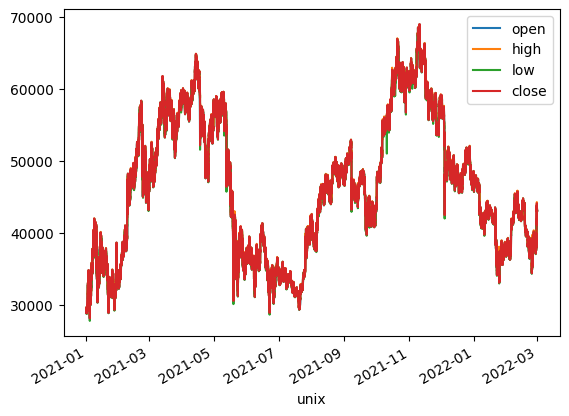

In [7]:
df.plot()

In [8]:
df.describe()

,open,high,low,close
count,610782.000000,610782.000000,610782.000000,610782.000000
mean,46482.265381,46509.783597,46454.085712,46482.567211
std,9453.990285,9454.798088,9453.135638,9454.107853
min,28093.810000,28397.520000,27734.000000,28073.030000
25%,38129.052500,38157.882500,38099.437500,38129.137500
50%,46666.960000,46697.745000,46636.710000,46667.295000
75%,54907.797500,54938.655000,54877.405000,54907.412500
max,69000.000000,69000.000000,68799.990000,69000.000000


# Get Y Value and resample to 5 min interval

In [10]:
df['y'] = df['close'].shift(-1)
df = df[:-1]
df = df.resample('5Min').asfreq().dropna()
#df['7ma'] = df['close'].rolling(window=7).mean()
#df['50ma'] = df['close'].rolling(window=50).mean()
#df['short_trend'] = df['7ma'].diff(7)
#df['long_trend'] = df['50ma'].diff(50)
#df['weekday'] = df.index.weekday
#df = df.dropna()


# Generate Train Test split

In [11]:
from sklearn.model_selection import train_test_split
random_state = 42
train_size = 0.8
X = df[['open', 'high', 'low', 'close']]
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=train_size, random_state=random_state) 

# Configure MLFlow endpoint

In [12]:
import os
import mlflow

os.environ["AWS_ACCESS_KEY_ID"] = "mlflow"
os.environ["AWS_SECRET_ACCESS_KEY"] = "mlflow123"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"http://mlflow-minio.mlflow.svc.cluster.local:9000/"
model_artifact_name = "model"

mlflow.set_tracking_uri("http://mlflow.mlflow.svc.cluster.local")
mlflow.set_experiment("bitcoin")

2022/09/22 10:14:08 INFO mlflow.tracking.fluent: Experiment with name 'bitcoin' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow/1', creation_time=None, experiment_id='1', last_update_time=None, lifecycle_stage='active', name='bitcoin', tags={}>

# Fit and export the model

In [21]:
import logging
import mlflow
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlflow.models.signature import infer_signature

np.random.seed(random_state)
tf.random.set_seed(random_state) 

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

if __name__ == "__main__":
    with mlflow.start_run():
        mlflow.tensorflow.autolog()
        
        model = Sequential()
        model.add(Dense(32, input_shape=(X_train.shape[-1],), activation="relu", name="hidden_layer"))
        model.add(Dense(32))
        model.add(Dense(1))
        model.compile(loss="mse", optimizer="adam")
        
        model.fit(X_train, y_train, epochs=10, batch_size=100, validation_split=.2)
               
        # Evaluate the best model with testing data.
        y_hat = model.predict(X_test)
        (rmse, mae, r2) = eval_metrics(y_test, y_hat)
        mlflow.log_param("framework", "tensorflow")
        mlflow.log_param("version", tf.__version__)
        mlflow.log_param("random_state", random_state)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        lr = res = {"lr_" + str(key): val for key, val in model.optimizer.get_config().items()}
        mlflow.log_params(lr)
        
        model_signature = infer_signature(X_train, y_train)
        info = mlflow.keras.log_model(model, model_artifact_name, registered_model_name="BitcoinForecast", signature=model_signature)
        
        uri = mlflow.get_artifact_uri()

Epoch 1/10
  1/782 [..............................] - ETA: 6:17 - loss: 3877792768.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_train_batch_end` time: 0.0016s). Check your callbacks.


782/782 [==============================] - 2s 1ms/step - loss: 40687220.0000 - val_loss: 16951.2949
Epoch 2/10
782/782 [==============================] - 1s 1ms/step - loss: 16351.5381 - val_loss: 16955.7188
Epoch 3/10
782/782 [==============================] - 1s 1ms/step - loss: 16390.4434 - val_loss: 16971.7090
Epoch 4/10
782/782 [==============================] - 1s 1ms/step - loss: 16481.0156 - val_loss: 16981.2949
Epoch 5/10
782/782 [==============================] - 1s 1ms/step - loss: 16618.4746 - val_loss: 17455.5957
Epoch 6/10
782/782 [==============================] - 1s 1ms/step - loss: 16797.1719 - val_loss: 17131.9238
Epoch 7/10
782/782 [==============================] - 1s 1ms/step - loss: 16878.0918 - val_loss: 19038.0078
Epoch 8/10
782/782 [==============================] - 1s 1ms/step - loss: 17208.2246 - val_loss: 20486.0098
Epoch 9/10
782/782 [==============================] - 1s 1ms/step - loss: 18428.3770 - val_loss: 20508.4844
Epoch 10/10
782/782 [===============

INFO:tensorflow:Assets written to: /tmp/tmpz9jraw1t/model/data/model/assets


764/764 [==============================] - 1s 623us/step


/home/pierre/miniconda3/envs/feast2/lib/python3.8/site-packages/mlflow/keras.py:405: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input.
  warnings.warn(


INFO:tensorflow:Assets written to: /tmp/tmpvo_7mjjo/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpvo_7mjjo/model/data/model/assets
Registered model 'BitcoinForecast' already exists. Creating a new version of this model...
2022/09/22 11:10:39 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: BitcoinForecast, version 2
Created version '2' of model 'BitcoinForecast'.


# Update the inferenseservice yaml

In [22]:
storage_uri = f"{uri}/{model_artifact_name}"

In [23]:
#https://github.com/ipython/ipython/issues/6701
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [24]:
%%writetemplate deployment/isvc.yaml

apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: "bitcoin-forecast"
  namespace: default
  labels:
    networking.knative.dev/visibility: cluster-local
spec:
  predictor:
    serviceAccountName: sa-s3
    model:
      modelFormat:
        name: mlflow
      protocolVersion: v2
      storageUri: {storage_uri}

In [34]:
%%writefile deployment/payload.json

{
  "parameters": {
    "content_type": "pd"
  },
  "inputs": [
      {
        "name": "open",
        "shape": [1],
        "datatype": "FP64",
        "data": [2000]
      },
      {
        "name": "high",
        "shape": [1],
        "datatype": "FP64",
        "data": [2200]
      },
      {
        "name": "low",
        "shape": [1],
        "datatype": "FP64",
        "data": [1900]
      },
      {
        "name": "close",
        "shape": [1],
        "datatype": "FP64",
        "data": [2050]
      }
  ]
}

Overwriting deployment/payload.json


In [35]:
!curl -v -H "bitcoin-forecast.default.svc.cluster.local" -H "Content-Type: application/json" -d @./deployment/payload.json \
http://bitcoin-forecast.default.svc.cluster.local/v2/models/bitcoin-forecast/infer

*   Trying 10.96.13.43:80...
* Connected to bitcoin-forecast.default.svc.cluster.local (10.96.13.43) port 80 (#0)
> POST /v2/models/bitcoin-forecast/infer HTTP/1.1
> Host: bitcoin-forecast.default.svc.cluster.local
> User-Agent: curl/7.81.0
> Accept: */*
> Content-Type: application/json
> Content-Length: 494
> 
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< content-length: 222
< content-type: application/json
< date: Thu, 22 Sep 2022 09:18:28 GMT
< server: istio-envoy
< x-envoy-upstream-service-time: 221
< 
* Connection #0 to host bitcoin-forecast.default.svc.cluster.local left intact
{"model_name":"bitcoin-forecast","model_version":null,"id":"40c8c107-94ee-46eb-848c-c943b98c1519","parameters":null,"outputs":[{"name":"predict","shape":[1,1],"datatype":"FP32","parameters":null,"data":[2095.2177734375]}]}